In [1]:
import pandas as pd
import numpy as np
from dataloaders.finbert_dataloaders import ValDataset
import datetime

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader
from dataloaders.finbert_dataloaders import ValDataset
import torch.nn as nn

/home/nickmoran/miniconda3/envs/st/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tweets = pd.read_csv("Tweet.csv")
company_tweet = pd.read_csv("Company_Tweet.csv")
aapl_tweet_ids = company_tweet[company_tweet['ticker_symbol'] == 'AAPL']
ids = aapl_tweet_ids['tweet_id'].tolist()
aapl_tweets = tweets[tweets['tweet_id'].isin(ids)]

In [3]:
aapl_tweets['post_date'] = pd.to_datetime(aapl_tweets['post_date'].apply(lambda x: datetime.datetime.fromtimestamp(x).isoformat()))
mask = (aapl_tweets['post_date'] >= pd.to_datetime(1514790000, unit='s')) & (aapl_tweets['post_date'] <= pd.to_datetime(1546239600, unit='s'))
time_tweets = aapl_tweets[mask]

/tmp/ipykernel_14224/2315667270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_tweets['post_date'] = pd.to_datetime(aapl_tweets['post_date'].apply(lambda x: datetime.datetime.fromtimestamp(x).isoformat()))


In [4]:
len(time_tweets), len(aapl_tweets)

(222646, 1425013)

In [5]:
hour_mask = (time_tweets['post_date'].dt.hour >= 9) & (time_tweets['post_date'].dt.hour <= 11)
time_tweets = time_tweets[hour_mask]
len(time_tweets)

48421

In [6]:
gb_date = time_tweets.groupby(time_tweets.post_date.dt.strftime('%y-%m-%d'))  

In [7]:
num_tweets_per_day = gb_date.count()['tweet_id']
idx = list(gb_date.indices.keys())

In [8]:
m = num_tweets_per_day.rolling(20).mean()
s = num_tweets_per_day.rolling(20).std()

In [9]:
trading_days = num_tweets_per_day.to_numpy() > (m+s)

In [10]:
trading_date = np.array(idx)[trading_days == True]
len(trading_date)

45

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    print('cleaning cache')
    torch.cuda.empty_cache()

In [12]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# The model will give softmax outputs for three labels: positive, negative or neutral (in this order)
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model = model.to(device=device)
model.eval()
print('ready!')

ready!


In [13]:
def maj_sent(news_articles):
    torch.cuda.empty_cache()        
    tokens_encoding = tokenizer(news_articles,max_length=64, padding='max_length', truncation=True, return_tensors="pt")
    val_loader = ValDataset(tokens_encoding)
    val_dataloader = DataLoader(val_loader, shuffle=False, batch_size=2)

    softmax = nn.Softmax(dim=1)
    
    mood = []

    for ids,attn_mask,ttype_ids in val_dataloader:
        ids = ids.to(device=device)
        attn_mask = attn_mask.to(device=device)
        ttype_ids = ttype_ids.to(device=device)

        output = model(input_ids=ids, attention_mask=attn_mask, token_type_ids=ttype_ids)
        output = softmax(output.logits)
     
        s = output.argmax(dim=1).cpu().numpy()
        s[s == 1] = -1
        s[s == 0] = 1
        s[s == 2] = 0

        mood.extend(s)

    return np.sign(sum(mood))


In [14]:
date_format = '%y-%m-%d'
date_format_chart = '%Y-%m-%d'

In [15]:
chart = pd.read_csv("./charts/APPLE1440.csv")
chart['date'] = pd.to_datetime(chart['date'].apply(lambda x: datetime.datetime.strptime(x, date_format_chart)))

In [16]:
hourly_chart = pd.read_csv("./charts/APPLE60.csv")
stock_time_format = '%H:%M'
dtime_gen = lambda x,y: datetime.datetime.combine(x,y.time())

# hourly_chart['time'] = hourly_chart['time'].apply(lambda x:  datetime.datetime.strptime(x, stock_time_format))
hourly_chart['date'] = hourly_chart['date'].apply(lambda x:  datetime.datetime.strptime(x, date_format_chart))

# hourly_chart['dtime'] = hourly_chart.apply(lambda x: dtime_gen(x.date, x.time), axis=1)

In [54]:
pred = []
ans = []
pnl = []

for i, d in enumerate(trading_date):
    date = datetime.datetime.strptime(d, date_format).strftime('%y-%m-%d')

    stk_mv = chart[chart['date'].dt.strftime('%y-%m-%d') == date]
    stk_mv_idx = chart[chart['date'].dt.strftime('%y-%m-%d') == date].index

    next_day = chart.iloc[stk_mv_idx[0] + 1]
    
    hr_start = hourly_chart[hourly_chart['date'].dt.strftime('%y-%m-%d') == date]
    hr_start = hr_start[hr_start['time'] == '15:30']
    
    #if the market isn't open
    if len(stk_mv) == 0:
        print('market closed', date, stk_mv,)
        break
    
    # direction = np.sign(stk_mv['close'].values - hr_start['open'].values)
    direction = np.sign(next_day['close'] - hr_start['open'].values)

    
    # pnl.append([hr_start['open'].values, stk_mv['close']])
    pnl.append([hr_start['open'].values[0], next_day['close']])

    
    mask = (time_tweets['post_date'].dt.strftime('%y-%m-%d') == date)
    daily_tweets = time_tweets[mask]

    sent = maj_sent(daily_tweets['body'].tolist())
    
    ans.extend(direction)
    pred.append(sent)

acc = sum(np.array(pred) == np.array(ans)) / len(ans)
print('ACC:',acc)
# ACC: 0.82 (tweets full lookahead)
# ACC: 0.6666666666666666 (tweets no lookhead, cutoff @ 12pm)
# ACC: 0.5531914893617021 (tweets no lookhead, cutoff @ 2pm)
# ACC: 0.7555555555555555 (tweets no lookhead, cutoff @ 11am) (15:30 here, 11am in mask)
# ACC: 0.673469387755102 (tweets no lookhead, cutoff @ 10am) (14:30 here, 10am in mask)

ACC: 0.6666666666666666


In [55]:
pnl = np.array(pnl)
pnl2 = pnl
pnl

array([[175.23, 171.3 ],
       [172.81, 171.4 ],
       [170.67, 167.9 ],
       [167.96, 167.05],
       [167.17, 166.56],
       [163.68, 156.  ],
       [177.78, 178.35],
       [179.13, 176.19],
       [174.03, 168.78],
       [169.65, 164.98],
       [173.42, 166.68],
       [166.92, 168.38],
       [166.83, 165.12],
       [166.58, 163.  ],
       [166.9 , 176.36],
       [176.03, 176.92],
       [182.95, 185.  ],
       [189.4 , 191.88],
       [192.13, 193.12],
       [184.87, 184.08],
       [192.19, 191.12],
       [193.8 , 189.98],
       [189.74, 195.64],
       [200.88, 207.42],
       [206.4 , 207.98],
       [219.47, 223.22],
       [223.83, 227.52],
       [228.63, 226.88],
       [221.13, 221.03],
       [222.2 , 226.61],
       [224.46, 223.95],
       [217.75, 219.24],
       [219.88, 220.52],
       [215.85, 211.8 ],
       [217.91, 214.1 ],
       [213.78, 218.7 ],
       [219.77, 212.99],
       [207.28, 201.53],
       [198.64, 204.  ],
       [195.83, 192.61],


In [56]:
delta = pnl2[:,1] - pnl2[:,0] #close - open 

In [57]:
win = np.array(pred)*delta
win

array([ 3.93,  1.41,  2.77,  0.91,  0.61,  7.68,  0.57,  2.94,  5.25,
       -4.67,  6.74, -1.46,  1.71,  3.58,  9.46,  0.89,  2.05,  2.48,
        0.99,  0.79, -1.07,  3.82, -5.9 ,  6.54,  1.58,  3.75,  3.69,
       -1.75, -0.1 ,  4.41,  0.51, -1.49, -0.64, -4.05,  3.81, -4.92,
       -6.78,  5.75, -5.36,  3.22, -0.76, -1.05,  1.87, -2.63,  9.69])

In [58]:
max(win),min(win), np.median(win), np.mean(win)

(9.689999999999998, -6.780000000000001, 1.4099999999999966, 1.3504444444444441)

In [59]:
import matplotlib.pyplot as plt

In [80]:
def roi(starting, prec):
  ret = []

  for p in prec:
    cash = starting
    cost = 0
    r = 0
    l = 0

    for i in range(len(win)):
      cash2trade = cash * p #percentage of the portfolio 

      stocks = cash2trade // pnl2[i][0]
      
      attmt = win[i] / pnl2[i][0]
      # if it goes down half a percent or more... cash out (stop loss)
      if attmt <= -0.005:
         r += -0.005
         cash += -0.005*pnl2[i][0]*stocks
         continue
            
      cash += win[i]*stocks


      r += (win[i])/(pnl2[i][0])
      
      if cash <= 0:
          break
    
    ret.append([((cash-starting)/starting)/p, cash-starting])
    # ret.append([r, cash-starting])
    # ret.append((cash-starting))


  return ret

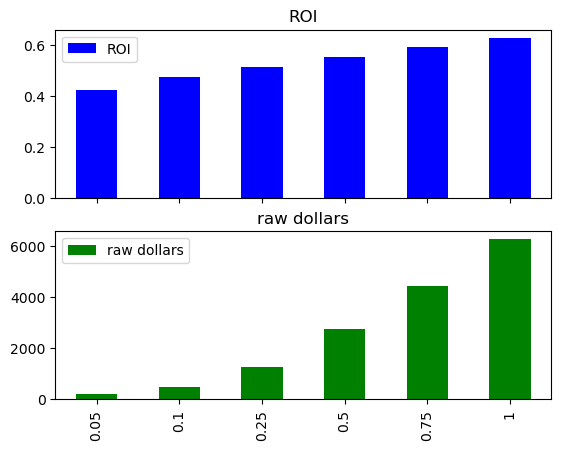

In [81]:
prec = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

rets = roi(10000, prec)

rets = np.array(rets)
ret_df = pd.DataFrame(rets, columns=['ROI', 'raw dollars'], index=[str(p) for p in prec])
ax = ret_df.plot.bar(subplots=True, color={"ROI": "blue", "raw dollars": "green"})

plt.show()